## Loading the dataset

In [1]:
import pandas as pd
df = pd.read_csv("../day_month.csv")
df.head()

,production,p_per_m2,p_max,panel_area,facade_area,total_panel_area,exploitation_ratio,air_temp_mean,air_temp_max,clearsky_ghi_mean,...,relative_humidity_max,surface_pressure_mean,surface_pressure_min,surface_pressure_max,wind_direction_100m_mean,wind_direction_100m_min,wind_direction_100m_max,wind_speed_100m_mean,wind_speed_100m_min,wind_speed_100m_max
0,8.075,143.0,210.0,1.72,218.0,94.6,0.434,4.063830,6.50,61.673648,...,95.675,1025.209907,1023.175,1027.325,210.491356,114.25,281.5,3.281959,1.625,5.025
1,0.700,143.0,210.0,1.72,218.0,94.6,0.434,4.221410,5.00,61.055629,...,95.350,1029.553147,1027.750,1031.600,221.406250,115.00,273.0,3.476042,1.650,5.000
2,1.325,143.0,210.0,1.72,218.0,94.6,0.434,6.932292,8.75,89.687500,...,92.875,1004.979167,1002.000,1009.450,202.578125,153.50,255.0,6.997396,5.025,9.425
3,1.300,143.0,210.0,1.72,218.0,94.6,0.434,5.822917,7.50,89.614583,...,92.700,1004.126042,1000.750,1010.600,216.354167,181.50,259.0,7.590625,5.450,9.650
4,18.250,143.0,210.0,1.72,218.0,94.6,0.434,6.647368,11.50,154.226316,...,85.625,1019.062632,1016.375,1021.425,154.531579,123.00,190.0,5.128947,3.625,7.500


In [2]:
df.shape

(6586, 34)

## Preoaring the (x,y) pairs

### Scaling the data

In [3]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df.values)

### Creating windows

In [4]:
production_column = 'production'

def get_target_column_index(df, target_column):
    for i, column in enumerate(df.columns):
        if column == target_column:
            return i

    return -1

In [5]:
import numpy as np

def get_windows(data, window_size=10):
    x = []
    y = []

    for i in range(window_size, len(data)):
        x.append(data[i-window_size:i])
        y.append(data[i][get_target_column_index(df, production_column)])

    return np.array(x), np.array(y)

In [6]:
window_size = 2*12  # 2*1h window
x, y = get_windows(data_scaled, window_size=window_size)

x.shape, y.shape

((6562, 24, 34), (6562,))

### Splitting the data

In [7]:
train_split_index = int(0.8 * len(df))
test_split_index = int(0.9 * len(df))

x_train, y_train = x[:train_split_index], y[:train_split_index]
x_test, y_test = x[train_split_index:test_split_index], y[train_split_index:test_split_index]
x_val, y_val = x[test_split_index:], y[test_split_index:]

x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((5268, 24, 34), (5268,), (659, 24, 34), (659,), (635, 24, 34), (635,))

### Plotting the splits

In [8]:
import matplotlib.pyplot as plt


def plot_time_series(timesteps, values, label, format='-^', start=0, end=None):
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("date")
    plt.ylabel("production")

    plt.legend(fontsize=14)
    plt.grid(True)

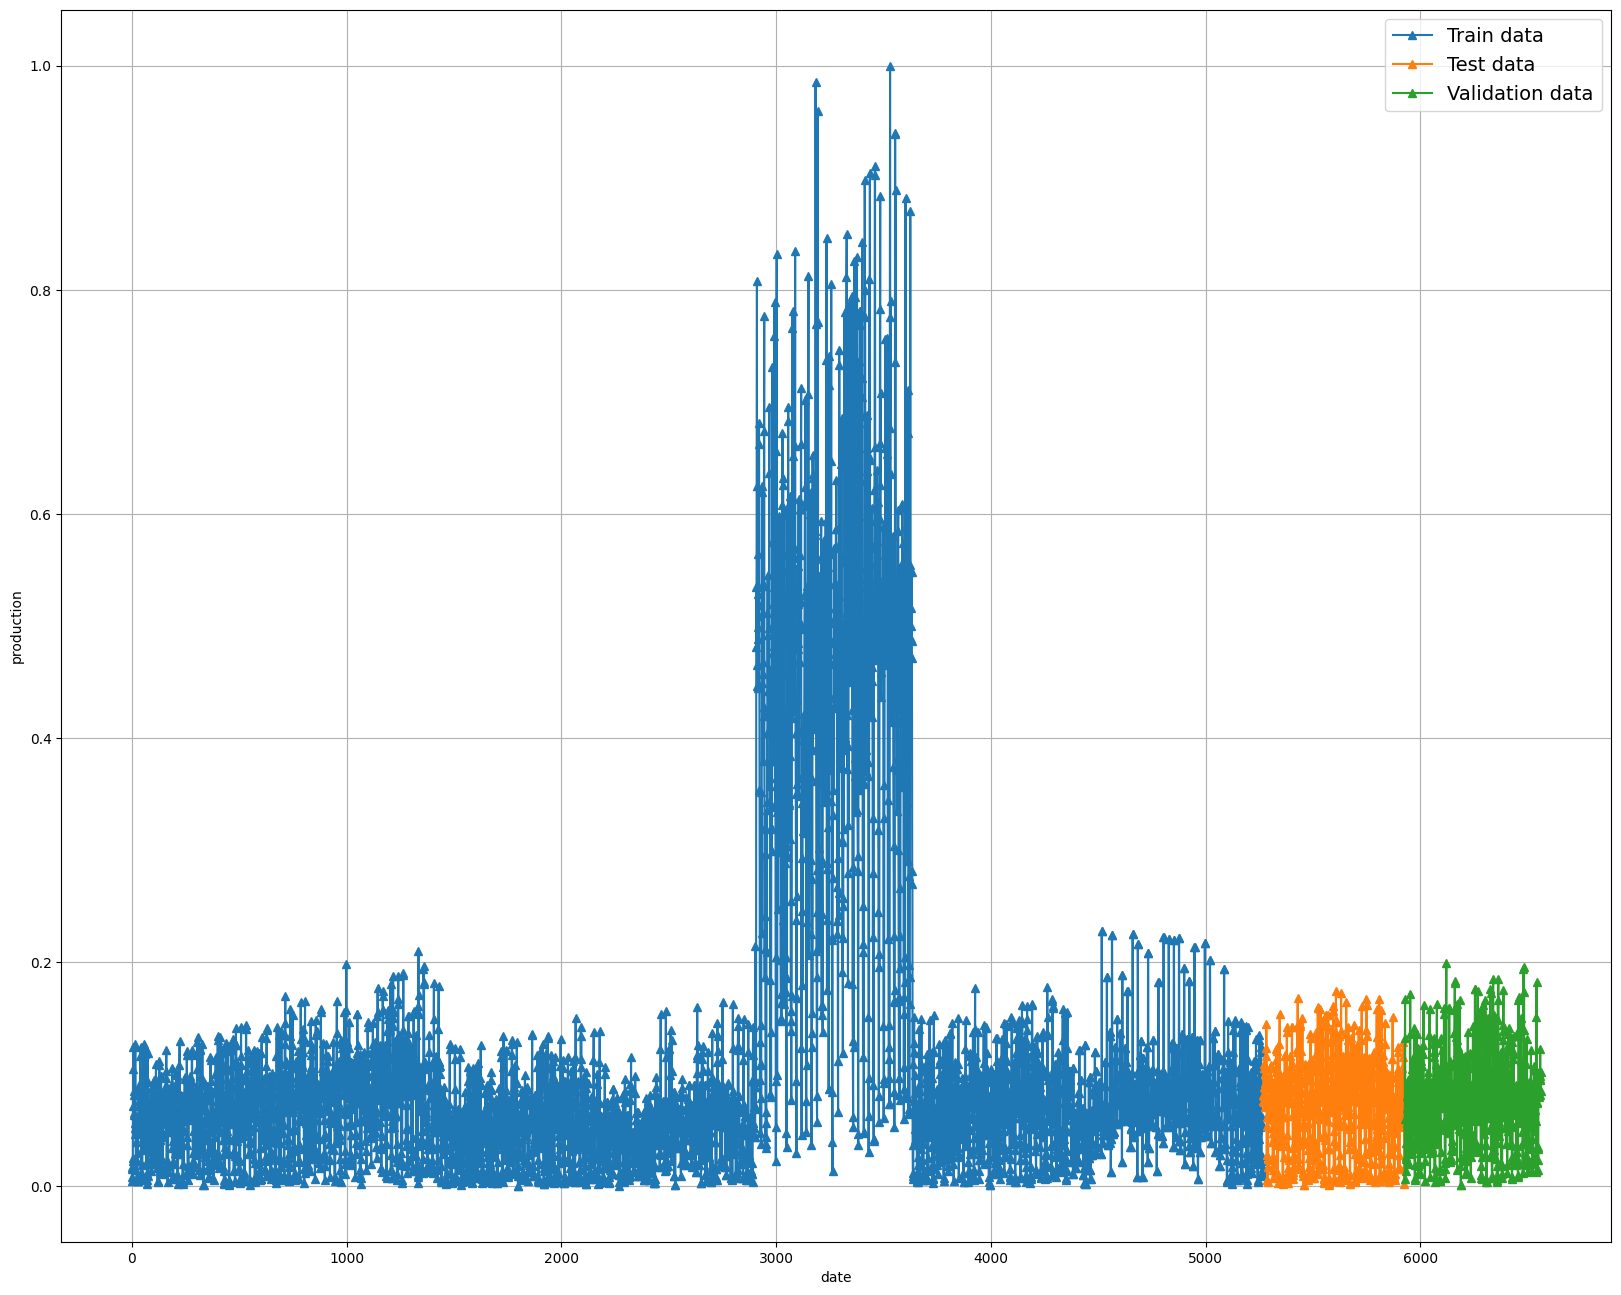

In [9]:
plt.figure(figsize=(20, 16))

timesteps = range(len(x_train))
plot_time_series(timesteps=timesteps, values=y_train, label="Train data")

timesteps = range(len(x_train), len(x_train) + len(x_test))
plot_time_series(timesteps=timesteps, values=y_test, label="Test data")

timesteps = range(len(x_train) + len(x_test),
                  len(x_train) + len(x_test) + len(x_val))
plot_time_series(timesteps=timesteps, values=y_val, label="Validation data")

### Preparing the performances metrics

In [10]:
import tensorflow as tf
from sklearn.metrics import r2_score

In [11]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return {
        'mse': mse,
        'r2': r2,
        'mae': mae,
        'mape': mape,
    }

In [12]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae_metric = tf.keras.metrics.MeanAbsoluteError()
    mse_metric = tf.keras.metrics.MeanSquaredError()

    mae_metric.update_state(y_true, y_pred)
    mse_metric.update_state(y_true, y_pred)

    mae = mae_metric.result().numpy()
    mse = mse_metric.result().numpy()
    r2 = r2_score(y_true.numpy(), y_pred.numpy())  # Assure-toi que y_true et y_pred sont des numpy arrays

    return {
        "mae": mae,
        "mse": mse,
        "r2": r2
    }

## Modeling

In [13]:
import os
import tensorflow as tf

from keras.layers import Dense, Dropout, LSTM, Flatten, ConvLSTM1D, MaxPool1D, GlobalMaxPool1D, Conv1D, Conv2D
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

### Plotting the loss

In [14]:
def plot_loss(history):
    plt.figure(figsize=(20, 8))

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

### Creating callbacks

In [15]:
stop_early = EarlyStopping(monitor='val_loss', patience=5)


def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                              verbose=0,
                                              save_best_only=True)

### Utils function

In [16]:
def make_preds(model, input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

## ConvLSTM

#### Preparing the model

In [17]:
x_train_conv_lstm = np.expand_dims(x_train, axis=2)
x_val_conv_lstm = np.expand_dims(x_val, axis=2)
x_test_conv_lstm = np.expand_dims(x_test, axis=2)

print(f"{x_train.shape} -> {x_train_conv_lstm.shape}")

(5268, 24, 34) -> (5268, 24, 1, 34)


In [18]:
tf.random.set_seed(42)

input_shape = (x_train_conv_lstm.shape[1:])
conv_lstm_model = tf.keras.Sequential([
    ConvLSTM1D(filters=64, kernel_size=(1,), activation='relu',
               return_sequences=True, input_shape=input_shape),
    ConvLSTM1D(filters=16, kernel_size=(1,),
               activation='tanh', return_sequences=False),
    Flatten(),
    Dense(units=64, activation='relu'),
    Dense(1, activation="linear")
], name="model_conv_lstm.keras")

conv_lstm_model.compile(loss="mae",
                        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0013603946616864242))

conv_lstm_model.summary()

C:\Users\yhoci\blocml\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "model_conv_lstm.keras"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm1d (ConvLSTM1D)             │ (None, 24, 1, 64)           │          25,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm1d_1 (ConvLSTM1D)           │ (None, 1, 16)               │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,681 (123.75 KB)

 Trainable params: 31,681 (123.75 KB)

 Non-trainable params: 0 (0.00 B)

#### Training the model convlstm

In [19]:
import os
import time
import logging
from codecarbon import EmissionsTracker


os.makedirs('emissions', exist_ok=True)

tracker_conv_lstm = EmissionsTracker(
    project_name="PEWH",
    co2_signal_api_token="9RkoBO6iipmoq",
    log_level=logging.INFO,
    output_file="emissions_conv_lstm.csv",
    output_dir='./emissions/',
    save_to_file=True,
    measure_power_secs=10
)

[codecarbon INFO @ 22:45:58] [setup] RAM Tracking...
[codecarbon INFO @ 22:45:58] [setup] CPU Tracking...
[codecarbon WARNING @ 22:45:58] No CPU tracking mode found. Falling back on CPU constant mode. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon WARNING @ 22:45:59] We saw that you have a AMD Ryzen 7 7840HS w/ Radeon 780M Graphics but we don't know it. Please contact us.
[codecarbon INFO @ 22:45:59] CPU Model on constant consumption mode: AMD Ryzen 7 7840HS w/ Radeon 780M Graphics
[codecarbon INFO @ 22:45:59] [setup] GPU Tracking...
[codecarbon INFO @ 22:45:59] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 22:45:59] >>> Tracker's metadata:
[codecarbon INFO @ 22:45:59]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 22:45:59]   Python version: 3.12.3
[codecarbon INFO @ 22:45:59]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 22:45:59]   Available RAM : 15.288 GB
[codecarbon INFO @ 22:45:59]   CPU count: 16
[codecarbon INFO @ 22:

In [20]:
def start_training_conv_lstm():
    start_time = time.time()
    conv_lstm_history = conv_lstm_model.fit(x=x_train_conv_lstm,
                                            y=y_train,
                                            epochs=300,
                                            verbose=1,
                                            batch_size=512,
                                            validation_data=(
                                                x_val_conv_lstm, y_val),
                                            callbacks=[create_model_checkpoint(model_name=conv_lstm_model.name)])
    training_duration = time.time() - start_time

    return conv_lstm_history, training_duration

In [21]:
tracker_conv_lstm.start()
try:
    history_conv_lstm, training_duration_conv_lstm = start_training_conv_lstm()
finally:
    tracker_conv_lstm.stop()

Epoch 1/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - loss: 0.0977 - val_loss: 0.0360
Epoch 2/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0534 - val_loss: 0.0326
Epoch 3/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0468 - val_loss: 0.0339
Epoch 4/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0454 - val_loss: 0.0353
Epoch 5/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0441 - val_loss: 0.0355
Epoch 6/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0431 - val_loss: 0.0368
Epoch 7/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0425 - val_loss: 0.0337
Epoch 8/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0411 - val_loss: 0.0322
Epoch 9/300
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0403

[codecarbon INFO @ 22:46:09] Energy consumed for RAM : 0.000016 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 22:46:09] Energy consumed for all CPUs : 0.000118 kWh. Total CPU Power : 42.5 W


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0403

[codecarbon INFO @ 22:46:09] Energy consumed for all GPUs : 0.000016 kWh. Total GPU Power : 5.843047783297617 W
[codecarbon INFO @ 22:46:09] 0.000151 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0403 - val_loss: 0.0313
Epoch 10/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0394 - val_loss: 0.0275
Epoch 11/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0388 - val_loss: 0.0300
Epoch 12/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0381 - val_loss: 0.0277
Epoch 13/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0380 - val_loss: 0.0273
Epoch 14/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0375 - val_loss: 0.0305
Epoch 15/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0372 - val_loss: 0.0279
Epoch 16/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0365 - val_loss: 0.0276
Epoch 17/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0361 - val_loss: 0.0280
Epoch 18/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0364 - val_loss: 0.0273
Epoch 19/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0362 - val_loss: 0.0275
Epoch 20/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - l

[codecarbon INFO @ 22:46:19] Energy consumed for RAM : 0.000032 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 22:46:20] Energy consumed for all CPUs : 0.000237 kWh. Total CPU Power : 42.5 W


 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0343

[codecarbon INFO @ 22:46:20] Energy consumed for all GPUs : 0.000039 kWh. Total GPU Power : 8.199819872656313 W
[codecarbon INFO @ 22:46:20] 0.000308 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0351 - val_loss: 0.0267
Epoch 28/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0347 - val_loss: 0.0270
Epoch 29/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0341 - val_loss: 0.0263
Epoch 30/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0346 - val_loss: 0.0266
Epoch 31/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0349 - val_loss: 0.0276
Epoch 32/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0347 - val_loss: 0.0291
Epoch 33/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0343 - val_loss: 0.0261
Epoch 34/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0345 - val_loss: 0.0273
Epoch 35/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0336 - val_loss: 0.0262
Epoch 36/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0342 - val_loss: 0.0265
Epoch 37/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0332 - val_loss: 0.0257
Epoch 38/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - l

[codecarbon INFO @ 22:46:30] Energy consumed for RAM : 0.000048 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 22:46:30] Energy consumed for all CPUs : 0.000355 kWh. Total CPU Power : 42.5 W


10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0331

[codecarbon INFO @ 22:46:30] Energy consumed for all GPUs : 0.000051 kWh. Total GPU Power : 4.362539397974253 W
[codecarbon INFO @ 22:46:30] 0.000454 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0331 - val_loss: 0.0255
Epoch 44/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0336 - val_loss: 0.0255
Epoch 45/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0333 - val_loss: 0.0260
Epoch 46/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0321 - val_loss: 0.0258
Epoch 47/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0322 - val_loss: 0.0250
Epoch 48/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0322 - val_loss: 0.0253
Epoch 49/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0324 - val_loss: 0.0253
Epoch 50/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0326 - val_loss: 0.0264
Epoch 51/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0316 - val_loss: 0.0252
Epoch 52/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0317 - val_loss: 0.0248
Epoch 53/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0319 - val_loss: 0.0252
Epoch 54/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - l

[codecarbon INFO @ 22:46:40] Energy consumed for RAM : 0.000064 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 22:46:40] Energy consumed for all CPUs : 0.000473 kWh. Total CPU Power : 42.5 W


 3/11 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0302

[codecarbon INFO @ 22:46:40] Energy consumed for all GPUs : 0.000064 kWh. Total GPU Power : 4.629816788288361 W
[codecarbon INFO @ 22:46:40] 0.000601 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0313 - val_loss: 0.0250
Epoch 62/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0316 - val_loss: 0.0248
Epoch 63/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0322 - val_loss: 0.0256
Epoch 64/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0309 - val_loss: 0.0241
Epoch 65/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0308 - val_loss: 0.0241
Epoch 66/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0312 - val_loss: 0.0247
Epoch 67/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0315 - val_loss: 0.0241
Epoch 68/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0313 - val_loss: 0.0263
Epoch 69/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0305 - val_loss: 0.0233
Epoch 70/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0305 - val_loss: 0.0238
Epoch 71/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0308 - val_loss: 0.0242
Epoch 72/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - l

[codecarbon INFO @ 22:46:50] Energy consumed for RAM : 0.000080 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 22:46:50] Energy consumed for all CPUs : 0.000591 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:46:50] Energy consumed for all GPUs : 0.000082 kWh. Total GPU Power : 6.5219616612778895 W
[codecarbon INFO @ 22:46:50] 0.000753 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0287 - val_loss: 0.0225
Epoch 79/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0288 - val_loss: 0.0224
Epoch 80/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0287 - val_loss: 0.0226
Epoch 81/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0283 - val_loss: 0.0225
Epoch 82/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0285 - val_loss: 0.0222
Epoch 83/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0287 - val_loss: 0.0224
Epoch 84/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0284 - val_loss: 0.0227
Epoch 85/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0287 - val_loss: 0.0221
Epoch 86/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0285 - val_loss: 0.0222
Epoch 87/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0281 - val_loss: 0.0220
Epoch 88/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0279 - val_loss: 0.0225
Epoch 89/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - l

[codecarbon INFO @ 22:47:00] Energy consumed for RAM : 0.000095 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 22:47:00] Energy consumed for all CPUs : 0.000709 kWh. Total CPU Power : 42.5 W


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0276

[codecarbon INFO @ 22:47:00] Energy consumed for all GPUs : 0.000101 kWh. Total GPU Power : 6.763436228588648 W
[codecarbon INFO @ 22:47:00] 0.000906 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0277 - val_loss: 0.0219
Epoch 96/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0275 - val_loss: 0.0217
Epoch 97/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0279 - val_loss: 0.0224
Epoch 98/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0278 - val_loss: 0.0218
Epoch 99/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0275 - val_loss: 0.0220
Epoch 100/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0279 - val_loss: 0.0232
Epoch 101/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0281 - val_loss: 0.0239
Epoch 102/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0279 - val_loss: 0.0246
Epoch 103/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0278 - val_loss: 0.0225
Epoch 104/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0273 - val_loss: 0.0223
Epoch 105/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0278 - val_loss: 0.0222
Epoch 106/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/s

[codecarbon INFO @ 22:47:10] Energy consumed for RAM : 0.000111 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 22:47:10] Energy consumed for all CPUs : 0.000827 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:47:10] Energy consumed for all GPUs : 0.000125 kWh. Total GPU Power : 8.549288733920129 W
[codecarbon INFO @ 22:47:10] 0.001064 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0275 - val_loss: 0.0225
Epoch 114/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0281 - val_loss: 0.0210
Epoch 115/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0275 - val_loss: 0.0242
Epoch 116/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0280 - val_loss: 0.0212
Epoch 117/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0269 - val_loss: 0.0217
Epoch 118/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0263 - val_loss: 0.0233
Epoch 119/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0275 - val_loss: 0.0236
Epoch 120/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0282 - val_loss: 0.0228
Epoch 121/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0268 - val_loss: 0.0210
Epoch 122/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0268 - val_loss: 0.0216
Epoch 123/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0272 - val_loss: 0.0218
Epoch 124/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50

[codecarbon INFO @ 22:47:20] Energy consumed for RAM : 0.000127 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 22:47:20] Energy consumed for all CPUs : 0.000946 kWh. Total CPU Power : 42.5 W


 2/11 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0245

[codecarbon INFO @ 22:47:20] Energy consumed for all GPUs : 0.000149 kWh. Total GPU Power : 8.672279692980847 W
[codecarbon INFO @ 22:47:20] 0.001222 kWh of electricity used since the beginning.


 6/11 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0251

[codecarbon INFO @ 22:47:20] 0.000229 g.CO2eq/s mean an estimation of 7.211439867296377 kg.CO2eq/year


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0257 - val_loss: 0.0215
Epoch 132/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0257 - val_loss: 0.0213
Epoch 133/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0253 - val_loss: 0.0228
Epoch 134/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0259 - val_loss: 0.0221
Epoch 135/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0259 - val_loss: 0.0223
Epoch 136/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0264 - val_loss: 0.0231
Epoch 137/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0268 - val_loss: 0.0213
Epoch 138/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0265 - val_loss: 0.0221
Epoch 139/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0268 - val_loss: 0.0208
Epoch 140/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0258 - val_loss: 0.0201
Epoch 141/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0256 - val_loss: 0.0207
Epoch 142/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49

[codecarbon INFO @ 22:47:30] Energy consumed for RAM : 0.000143 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 22:47:30] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:47:30] Energy consumed for all GPUs : 0.000159 kWh. Total GPU Power : 3.472081928643887 W
[codecarbon INFO @ 22:47:30] 0.001365 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0245 - val_loss: 0.0208
Epoch 149/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0248 - val_loss: 0.0213
Epoch 150/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0245 - val_loss: 0.0203
Epoch 151/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0244 - val_loss: 0.0210
Epoch 152/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0252 - val_loss: 0.0218
Epoch 153/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0257 - val_loss: 0.0213
Epoch 154/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0249 - val_loss: 0.0220
Epoch 155/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0252 - val_loss: 0.0235
Epoch 156/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0265 - val_loss: 0.0225
Epoch 157/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0267 - val_loss: 0.0212
Epoch 158/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0255 - val_loss: 0.0202
Epoch 159/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47

[codecarbon INFO @ 22:47:40] Energy consumed for RAM : 0.000159 kWh. RAM Power : 5.732982158660889 W


 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0244

[codecarbon INFO @ 22:47:40] Energy consumed for all CPUs : 0.001182 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:47:40] Energy consumed for all GPUs : 0.000169 kWh. Total GPU Power : 3.9119721081216103 W
[codecarbon INFO @ 22:47:40] 0.001510 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0246 - val_loss: 0.0226
Epoch 167/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0250 - val_loss: 0.0202
Epoch 168/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0238 - val_loss: 0.0216
Epoch 169/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0241 - val_loss: 0.0222
Epoch 170/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0242 - val_loss: 0.0203
Epoch 171/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0237 - val_loss: 0.0207
Epoch 172/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0236 - val_loss: 0.0207
Epoch 173/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0236 - val_loss: 0.0201
Epoch 174/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0237 - val_loss: 0.0205
Epoch 175/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0235 - val_loss: 0.0209
Epoch 176/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0234 - val_loss: 0.0202
Epoch 177/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48

[codecarbon INFO @ 22:47:50] Energy consumed for RAM : 0.000175 kWh. RAM Power : 5.732982158660889 W


 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0233

[codecarbon INFO @ 22:47:50] Energy consumed for all CPUs : 0.001300 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:47:50] Energy consumed for all GPUs : 0.000182 kWh. Total GPU Power : 4.444343840212037 W
[codecarbon INFO @ 22:47:50] 0.001656 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0237 - val_loss: 0.0233
Epoch 185/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0252 - val_loss: 0.0199
Epoch 186/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0230 - val_loss: 0.0200
Epoch 187/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0238 - val_loss: 0.0210
Epoch 188/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0239 - val_loss: 0.0233
Epoch 189/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0245 - val_loss: 0.0201
Epoch 190/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0232 - val_loss: 0.0204
Epoch 191/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0233 - val_loss: 0.0196
Epoch 192/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0235 - val_loss: 0.0210
Epoch 193/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0247 - val_loss: 0.0214
Epoch 194/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0246 - val_loss: 0.0207
Epoch 195/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52

[codecarbon INFO @ 22:48:00] Energy consumed for RAM : 0.000191 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 22:48:00] Energy consumed for all CPUs : 0.001418 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:48:00] Energy consumed for all GPUs : 0.000198 kWh. Total GPU Power : 5.8934988420081265 W
[codecarbon INFO @ 22:48:00] 0.001807 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0230 - val_loss: 0.0195
Epoch 203/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0232 - val_loss: 0.0192
Epoch 204/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0235 - val_loss: 0.0197
Epoch 205/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0231 - val_loss: 0.0224
Epoch 206/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0235 - val_loss: 0.0249
Epoch 207/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0249 - val_loss: 0.0194
Epoch 208/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0242 - val_loss: 0.0215
Epoch 209/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0229 - val_loss: 0.0201
Epoch 210/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0231 - val_loss: 0.0190
Epoch 211/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0230 - val_loss: 0.0237
Epoch 212/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0241 - val_loss: 0.0194
Epoch 213/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52

[codecarbon INFO @ 22:48:10] Energy consumed for RAM : 0.000207 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 22:48:10] Energy consumed for all CPUs : 0.001536 kWh. Total CPU Power : 42.5 W


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0217

[codecarbon INFO @ 22:48:10] Energy consumed for all GPUs : 0.000215 kWh. Total GPU Power : 6.070312500885814 W
[codecarbon INFO @ 22:48:10] 0.001958 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0217 - val_loss: 0.0203
Epoch 219/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0222 - val_loss: 0.0188
Epoch 220/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0221 - val_loss: 0.0202
Epoch 221/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0220 - val_loss: 0.0217
Epoch 222/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0227 - val_loss: 0.0196
Epoch 223/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0220 - val_loss: 0.0186
Epoch 224/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0213 - val_loss: 0.0202
Epoch 225/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0233 - val_loss: 0.0195
Epoch 226/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0218 - val_loss: 0.0184
Epoch 227/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0216 - val_loss: 0.0227
Epoch 228/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0226 - val_loss: 0.0193
Epoch 229/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52

[codecarbon INFO @ 22:48:20] Energy consumed for RAM : 0.000223 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 22:48:20] Energy consumed for all CPUs : 0.001654 kWh. Total CPU Power : 42.5 W


 5/11 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0218

[codecarbon INFO @ 22:48:20] Energy consumed for all GPUs : 0.000236 kWh. Total GPU Power : 7.433658717078043 W
[codecarbon INFO @ 22:48:20] 0.002113 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0219 - val_loss: 0.0193
Epoch 236/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0219 - val_loss: 0.0190
Epoch 237/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0215 - val_loss: 0.0211
Epoch 238/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0213 - val_loss: 0.0195
Epoch 239/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0211 - val_loss: 0.0180
Epoch 240/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0213 - val_loss: 0.0191
Epoch 241/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0220 - val_loss: 0.0197
Epoch 242/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0222 - val_loss: 0.0186
Epoch 243/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0218 - val_loss: 0.0222
Epoch 244/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0221 - val_loss: 0.0182
Epoch 245/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0212 - val_loss: 0.0221
Epoch 246/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47

[codecarbon INFO @ 22:48:30] Energy consumed for RAM : 0.000238 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 22:48:30] Energy consumed for all CPUs : 0.001772 kWh. Total CPU Power : 42.5 W


10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0209

[codecarbon INFO @ 22:48:30] Energy consumed for all GPUs : 0.000244 kWh. Total GPU Power : 2.8781884662449366 W
[codecarbon INFO @ 22:48:30] 0.002254 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0209 - val_loss: 0.0179
Epoch 253/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0205 - val_loss: 0.0188
Epoch 254/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0203 - val_loss: 0.0203
Epoch 255/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0204 - val_loss: 0.0218
Epoch 256/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0216 - val_loss: 0.0192
Epoch 257/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0215 - val_loss: 0.0206
Epoch 258/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0207 - val_loss: 0.0177
Epoch 259/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0205 - val_loss: 0.0182
Epoch 260/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0203 - val_loss: 0.0207
Epoch 261/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0212 - val_loss: 0.0185
Epoch 262/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0210 - val_loss: 0.0202
Epoch 263/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50

[codecarbon INFO @ 22:48:40] Energy consumed for RAM : 0.000254 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 22:48:40] Energy consumed for all CPUs : 0.001891 kWh. Total CPU Power : 42.5 W


 5/11 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0190

[codecarbon INFO @ 22:48:40] Energy consumed for all GPUs : 0.000265 kWh. Total GPU Power : 7.765761513428817 W
[codecarbon INFO @ 22:48:40] 0.002410 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0195 - val_loss: 0.0178
Epoch 271/300
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0197

[codecarbon INFO @ 22:48:40] 0.000223 g.CO2eq/s mean an estimation of 7.020267650789291 kg.CO2eq/year


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0199 - val_loss: 0.0178
Epoch 272/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0191 - val_loss: 0.0192
Epoch 273/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0196 - val_loss: 0.0173
Epoch 274/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0198 - val_loss: 0.0187
Epoch 275/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0197 - val_loss: 0.0180
Epoch 276/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0199 - val_loss: 0.0177
Epoch 277/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0201 - val_loss: 0.0193
Epoch 278/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0202 - val_loss: 0.0190
Epoch 279/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0201 - val_loss: 0.0183
Epoch 280/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0204 - val_loss: 0.0185
Epoch 281/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0203 - val_loss: 0.0179
Epoch 282/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48

[codecarbon INFO @ 22:48:50] Energy consumed for RAM : 0.000270 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 22:48:50] Energy consumed for all CPUs : 0.002009 kWh. Total CPU Power : 42.5 W


 3/11 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0194

[codecarbon INFO @ 22:48:50] Energy consumed for all GPUs : 0.000279 kWh. Total GPU Power : 5.002655761877659 W
[codecarbon INFO @ 22:48:50] 0.002558 kWh of electricity used since the beginning.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0193 - val_loss: 0.0196
Epoch 289/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0195 - val_loss: 0.0176
Epoch 290/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0195 - val_loss: 0.0177
Epoch 291/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0190 - val_loss: 0.0191
Epoch 292/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0196 - val_loss: 0.0185
Epoch 293/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0200 - val_loss: 0.0182
Epoch 294/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0200 - val_loss: 0.0179
Epoch 295/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0194 - val_loss: 0.0191
Epoch 296/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0197 - val_loss: 0.0181
Epoch 297/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0198 - val_loss: 0.0179
Epoch 298/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0188 - val_loss: 0.0186
Epoch 299/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54

[codecarbon INFO @ 22:48:57] Energy consumed for RAM : 0.000282 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 22:48:57] Energy consumed for all CPUs : 0.002095 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:48:57] Energy consumed for all GPUs : 0.000290 kWh. Total GPU Power : 5.344292293731738 W
[codecarbon INFO @ 22:48:57] 0.002667 kWh of electricity used since the beginning.


#### Ploting the loss

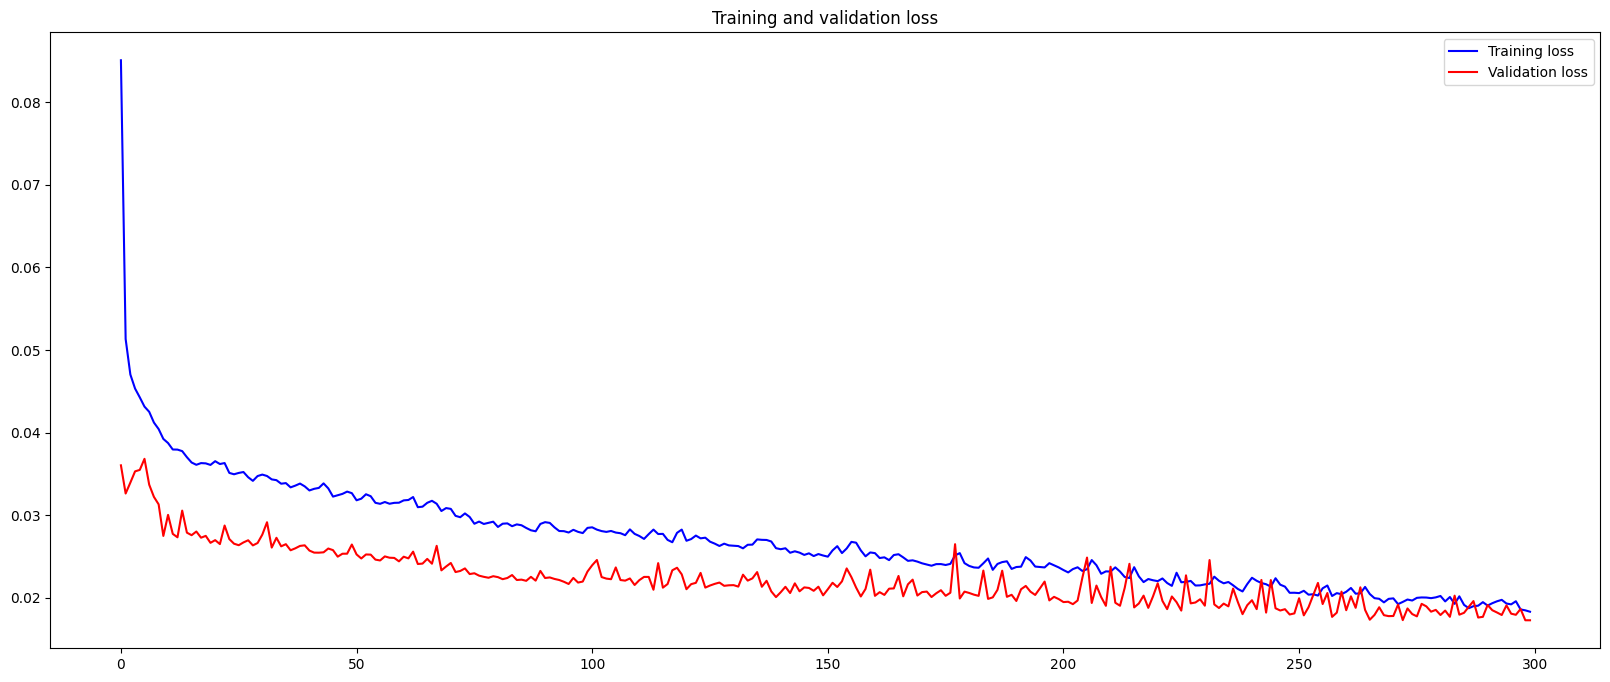

In [22]:
plot_loss(history_conv_lstm)

In [23]:
conv_lstm_model = tf.keras.models.load_model(
    "model_experiments/model_conv_lstm.keras")

model_preds = make_preds(conv_lstm_model, x_test_conv_lstm)
model_results = evaluate_preds(y_true=tf.squeeze(y_test),
                               y_pred=model_preds)

model_results

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step 


{'mae': np.float32(0.014763304),
 'mse': np.float32(0.00036555433),
 'r2': 0.7920278310775757}

#### Plot predictions

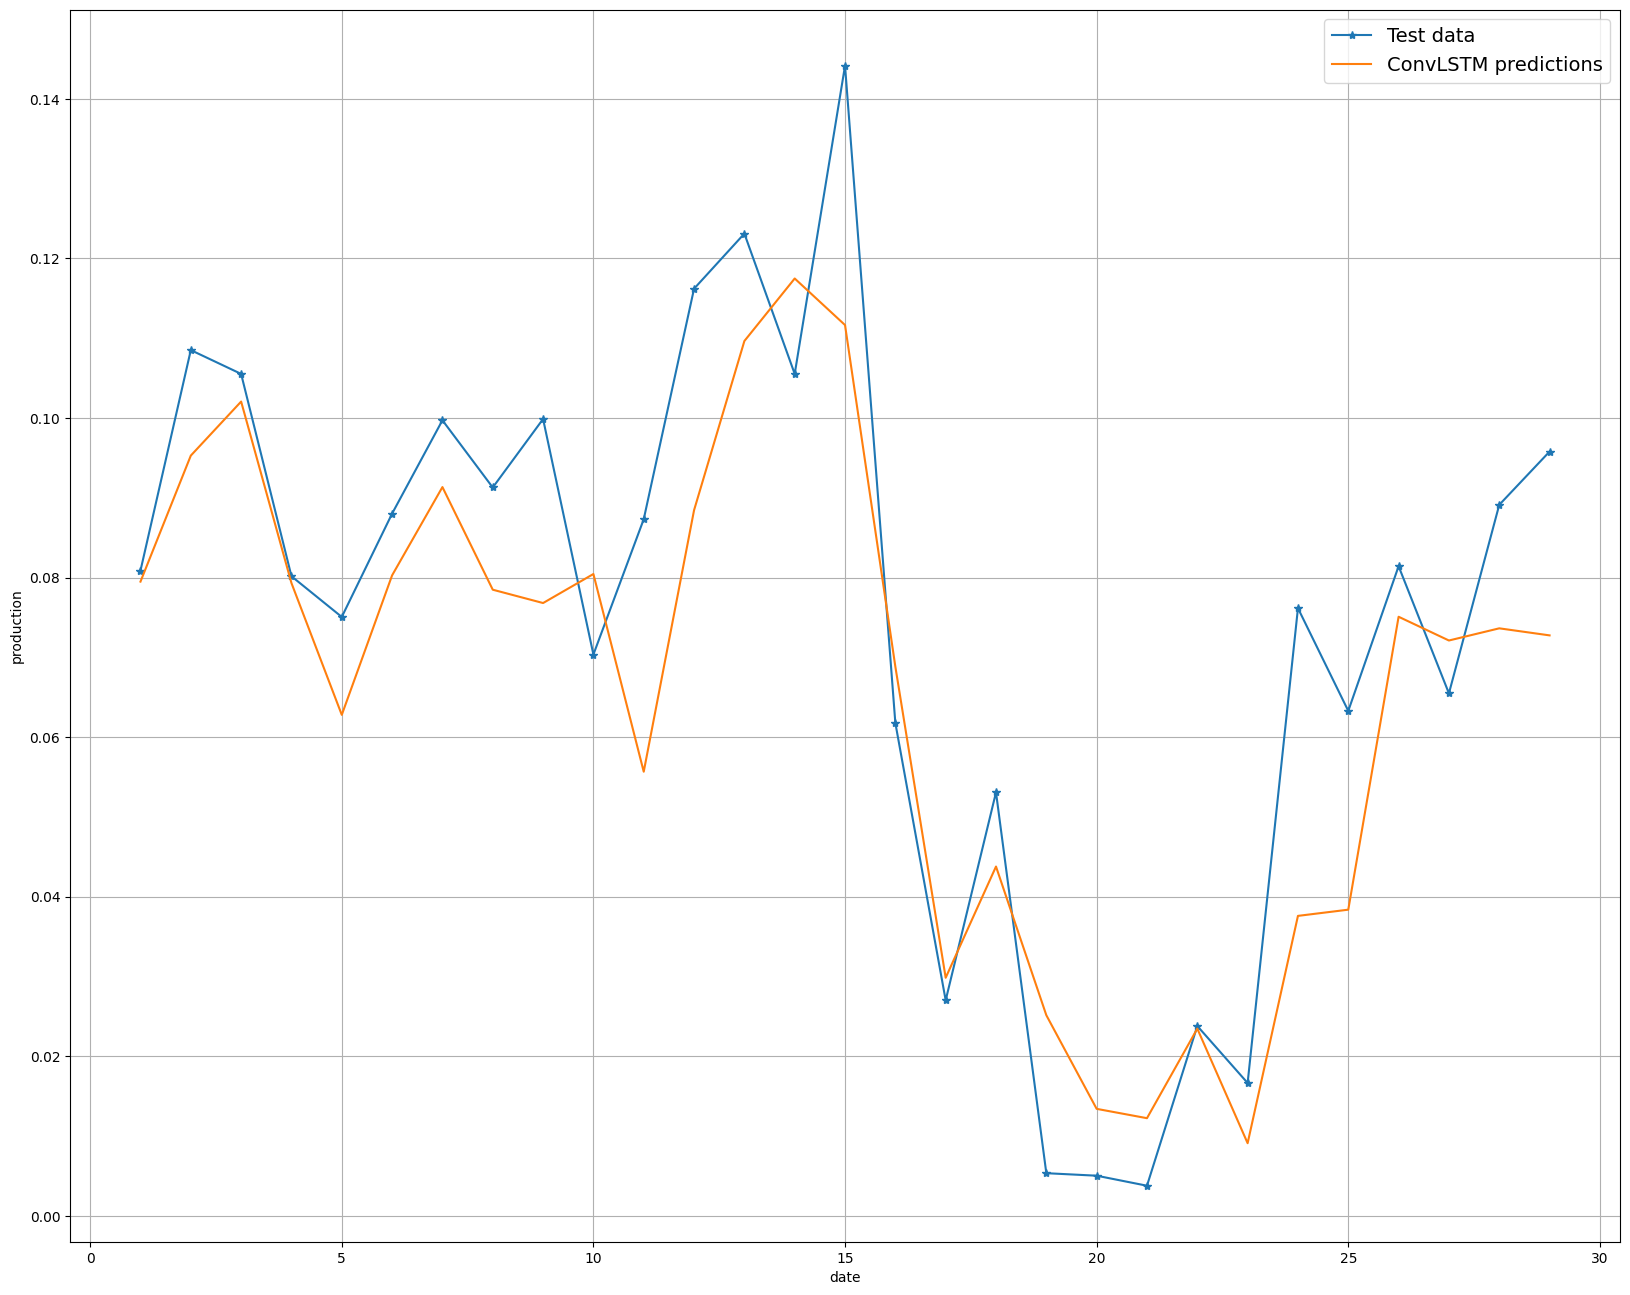

In [24]:
import numpy as np

start_offset = 1
end_offset = 30
plt.figure(figsize=(20, 16))


plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=y_test,
    start=start_offset,
    end=end_offset,
    format='-*',
    label="Test data"
)

plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=model_preds,
    start=start_offset,
    end=end_offset,
    format="-",
    label="ConvLSTM predictions"
)